In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import numpy as np
import re
import seaborn as sns

PROJECT_ROOT = Path.cwd().parent  
DATA_DIR = PROJECT_ROOT / "data" / "sales_agg_no_site"

In [ ]:
encoded_data = pd.read_excel(DATA_DIR / "sales_105_agg_no_site.xlsx")
calendar_data = pd.read_excel(DATA_DIR / "calendar.xlsx")

encoded_data['time_dt'] = pd.to_datetime(encoded_data['time'].str[1:], format='%Y%j')
df = pd.merge(encoded_data, calendar_data, left_on='time_dt', right_on='ForecastTime')

def to_snake_case(name):
    name = name.strip()
    name = re.sub(r"[ -]+", "_", name)
    name = name.lower()
    name = re.sub(r"_+", "_", name)
    return name

df.columns = [to_snake_case(col) for col in df.columns]
df = df.drop(columns=["usertime", "forecasttime", "time", "dept_no"])
df.head()

,pricing_line,price_zone,sales,time_dt
0,Solids - Plates - Dessert Plate - Paper - Good...,Base Zone,7838,2022-02-05
1,Solids - Tablecovers - Plastic - Good - 1CT,Base Zone,35380,2021-02-13
2,Solids - Drinkware - Large Cup - Plastic - Goo...,Base Zone,14820,2021-01-30
3,Solids - Tablecovers - Round - Good - 1CT,Zone B,2163,2021-02-20
4,Solids - Napkins - Beverage - Good - 125CT,Base Zone,5,2023-02-11


In [ ]:
import re
import pandas as pd

def parse_pricing_line(line: str) -> pd.Series:
    """
    Parses a pricing_line string into 5 components:
        - Category
        - Item_Type
        - Size_Capacity
        - Material
        - Quality
    
    Returns a pandas Series with these 5 values (some may be None).
    Handles all variants seen in your dataset.
    """
    if not isinstance(line, str) or not line.strip():
        return pd.Series([None] * 5)
    
    parts = [p.strip() for p in line.split(' - ') if p.strip()]
    if len(parts) < 2:
        return pd.Series([None] * 5)
    
    category = parts[1]
    attrs = parts[2:]
    
    # Known sets
    materials = {'PLASTIC', 'PAPER', 'FOAM', 'REUSABLE', 'BAMBOO', 'SUGARCANE'}
    
    qualities = {
        'GOOD', 'BETTER', 'BEST', 'PREMIUM', 'ECO', 'DELUXE', 'STURDY',
        'EXTRA STURDY', 'PREMIUM RECTANGULAR', 'RECTANGULAR'
    }
    
    # Descriptive words that belong to item name (not material/quality/size)
    item_modifiers = {
        'CLEAR', 'BOX', 'BOXED', 'DIVIDED', 'FLANNEL BACKED', 'LARGE', 'SMALL', 'MEDIUM',
        'BUFFET', 'ASSORTED', 'ROUND', 'BEVERAGE', 'DINNER', 'LUNCH', 'WITH LID',
        'DESSERT', 'BREAKFAST', 'COFFEE', 'SHOT', 'MARGARITA', 'MARTINI', 'WINE', 'CHAMPAGNE',
        'BEER', 'TUMBLER', 'FLUTE', 'GLASS', 'CUP', 'PLATE', 'BOWL', 'KIT', '& DINNER SET'
    }
    
    def is_quality(s: str) -> bool:
        up = s.upper()
        return up in qualities or any(q in up for q in ['PREMIUM', 'STURDY', 'DELUXE', 'EXTRA', 'RECTANGULAR'])
    
    def is_material(s: str) -> bool:
        return s.upper() in materials
    
    def is_pack_size(s: str) -> bool:
        up = s.upper()
        # Ignore pure numbers that look like codes
        if up.isdigit() and len(up) > 3:
            return False
        # Main size patterns
        if re.search(r'\d+(\.\d+)?\s*(CT|OZ|GAL|QT|L|ML|INCH?|FT|CM|"|X\s*\d+)', up):
            return True
        if up.endswith('CT') and up[:-2].replace('.', '').isdigit():
            return True
        return False
    
    quality = None
    material = None
    size = None
    item_parts = []
    
    i = 0
    while i < len(attrs):
        part = attrs[i]
        up = part.upper()
        
        # Two-word quality first
        if i + 1 < len(attrs):
            combined = f"{part} {attrs[i+1]}"
            if is_quality(combined) and quality is None:
                quality = combined
                i += 2
                continue
        
        # Material
        if is_material(part) and material is None:
            material = part
            i += 1
            continue
        
        # Quality
        if is_quality(part) and quality is None:
            quality = part
            i += 1
            continue
        
        # Size / capacity (we keep the last valid one)
        if is_pack_size(part):
            size = part  # overwrite → last one usually is pack count
            i += 1
            continue
        
        # Descriptive modifiers → item type
        if any(mod in up for mod in item_modifiers) or up in item_modifiers:
            item_parts.append(part)
            i += 1
            continue
        
        # Default: part of item name
        item_parts.append(part)
        i += 1
    
    item_type = ' '.join(item_parts).strip() if item_parts else None
    
    # Special cases / cleanups
    if item_type == 'None':
        item_type = None
    
    # If no item description at all, but we have category + attributes, fallback to category
    if not item_type and len(attrs) > 0:
        non_size_attrs = [p for p in attrs if not is_pack_size(p)]
        if non_size_attrs:
            item_type = ' '.join(non_size_attrs).strip()
    
    return pd.Series([
        category,
        item_type,
        size,
        material,
        quality
    ], index=['Category', 'Item_Type', 'Size_Capacity', 'Material', 'Quality'])


df[['Category', 'Item_Type', 'Size_Capacity', 'Material', 'Quality']] = df['pricing_line'].apply(parse_pricing_line)
df

,pricing_line,price_zone,sales,time_dt,Category,Item_Type,Size_Capacity,Material,Quality
0,Solids - Plates - Dessert Plate - Paper - Good...,Base Zone,7838,2022-02-05,Plates,Dessert Plate,50CT,Paper,Good
1,Solids - Tablecovers - Plastic - Good - 1CT,Base Zone,35380,2021-02-13,Tablecovers,Plastic Good,1CT,Plastic,Good
2,Solids - Drinkware - Large Cup - Plastic - Goo...,Base Zone,14820,2021-01-30,Drinkware,Large Cup,50CT,Plastic,Good
3,Solids - Tablecovers - Round - Good - 1CT,Zone B,2163,2021-02-20,Tablecovers,Round,1CT,None,Good
4,Solids - Napkins - Beverage - Good - 125CT,Base Zone,5,2023-02-11,Napkins,Beverage,125CT,None,Good
...,...,...,...,...,...,...,...,...,...
9561,Solids - Drinkware - Small Champagne Flute - P...,Web,61,2023-02-18,Drinkware,Small Champagne Flute,32CT,Plastic,Good
9562,Solids - Plates - Dessert Plate - Plastic - Pr...,Alaska,1,2022-01-29,Plates,Dessert Plate,32CT,None,Plastic Premium Rectangular
9563,Solids - Plates - Dinner Plate - Plastic - Pre...,Alaska,0,2024-02-10,Plates,Dinner Plate,16CT,None,Plastic Premium
9564,Solids - Tablecovers - Rolls - Plastic - 40IN ...,Alaska,4,2021-02-06,Tablecovers,Rolls,40IN X 250FT,Plastic,None


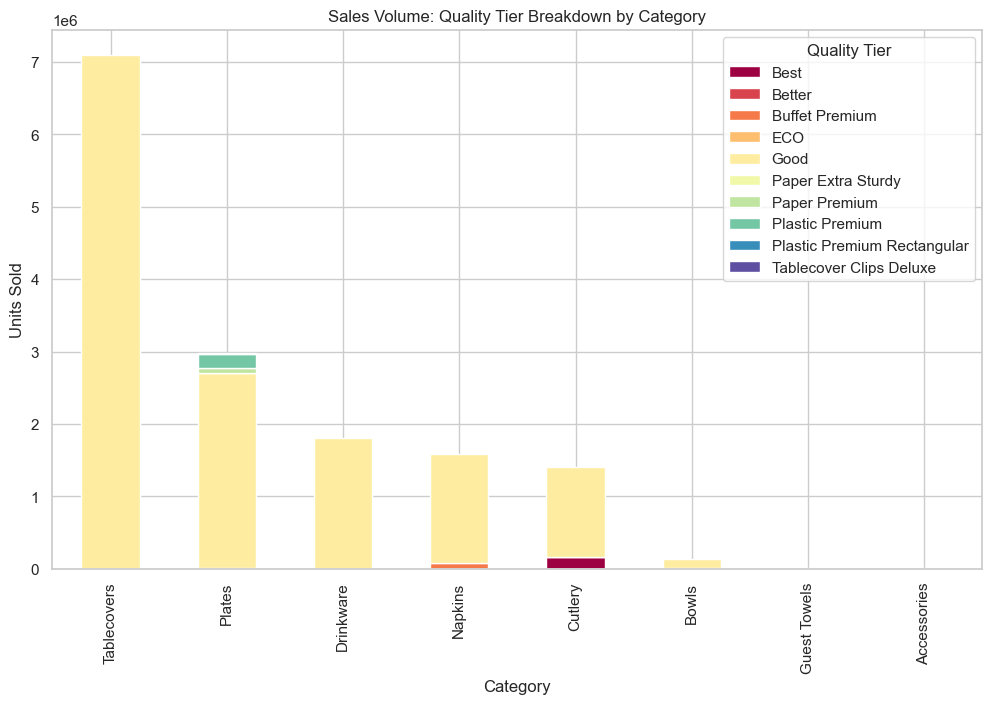

In [ ]:
# Create a pivot table for Category and Quality
quality_mix = df.groupby(['Category', 'Quality'])['sales'].sum().unstack().fillna(0)

# Sort by total volume
quality_mix['Total'] = quality_mix.sum(axis=1)
quality_mix = quality_mix.sort_values('Total', ascending=False).drop(columns='Total')

# Plot
quality_mix.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='Spectral')
plt.title('Sales Volume: Quality Tier Breakdown by Category')
plt.ylabel('Units Sold')
plt.legend(title='Quality Tier')
plt.show()

In [ ]:
df

,pricing_line,price_zone,sales,time_dt,Category,Item_Type,Size_Capacity,Material,Quality
0,Solids - Plates - Dessert Plate - Paper - Good...,Base Zone,7838,2022-02-05,Plates,Dessert Plate,50CT,Paper,Good
1,Solids - Tablecovers - Plastic - Good - 1CT,Base Zone,35380,2021-02-13,Tablecovers,Plastic Good,1CT,Plastic,Good
2,Solids - Drinkware - Large Cup - Plastic - Goo...,Base Zone,14820,2021-01-30,Drinkware,Large Cup,50CT,Plastic,Good
3,Solids - Tablecovers - Round - Good - 1CT,Zone B,2163,2021-02-20,Tablecovers,Round,1CT,None,Good
4,Solids - Napkins - Beverage - Good - 125CT,Base Zone,5,2023-02-11,Napkins,Beverage,125CT,None,Good
...,...,...,...,...,...,...,...,...,...
9561,Solids - Drinkware - Small Champagne Flute - P...,Web,61,2023-02-18,Drinkware,Small Champagne Flute,32CT,Plastic,Good
9562,Solids - Plates - Dessert Plate - Plastic - Pr...,Alaska,1,2022-01-29,Plates,Dessert Plate,32CT,None,Plastic Premium Rectangular
9563,Solids - Plates - Dinner Plate - Plastic - Pre...,Alaska,0,2024-02-10,Plates,Dinner Plate,16CT,None,Plastic Premium
9564,Solids - Tablecovers - Rolls - Plastic - 40IN ...,Alaska,4,2021-02-06,Tablecovers,Rolls,40IN X 250FT,Plastic,None
